<a href="https://colab.research.google.com/github/rashofner/exercise13123/blob/main/art_cloaking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4iourz2m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4iourz2m
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git+https://github.com/openai/CLIP.git lpips pytorch-msssim

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_x7ztpao
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_x7ztpao
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install timm --quiet

In [ ]:
!pip install opencv-contrib-python --quiet

In [ ]:
# importing Packages
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn.functional as F
import clip
from PIL import Image
import lpips
from pytorch_msssim import ssim
import timm
import torchvision.transforms as T
import skimage.feature
import matplotlib.pyplot as plt

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Using torch device type: {device}")

Using torch device type: cuda


In [ ]:
dino_models = timm.list_models('*dino*')
print("Available DINO models:\n", "\n".join(dino_models))

Available DINO models:
 vit_base_patch14_dinov2
vit_base_patch14_reg4_dinov2
vit_giant_patch14_dinov2
vit_giant_patch14_reg4_dinov2
vit_large_patch14_dinov2
vit_large_patch14_reg4_dinov2
vit_small_patch14_dinov2
vit_small_patch14_reg4_dinov2


In [ ]:
model_name = 'vit_base_patch14_dinov2'
dino_model = timm.create_model(model_name, pretrained=True)
dino_model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!ls ./drive/MyDrive/images

Unknown-10.jpeg  Unknown-2.jpeg  Unknown-4.jpeg  Unknown-6.jpeg  Unknown-8.jpeg
Unknown-1.jpeg	 Unknown-3.jpeg  Unknown-5.jpeg  Unknown-7.jpeg  Unknown-9.jpeg


In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 31.4MiB/s]


In [ ]:
# compute embeddings for all images
# path to folder of labeled images
img_folder = "./drive/MyDrive/images"

# iterate through all images in folder
embeddings = {}
for fname in os.listdir(img_folder):
    if not fname.lower().endswith(('.png','.jpg','.jpeg')):
        continue

    # load image
    img_path = os.path.join(img_folder, fname)
    img = Image.open(img_path).convert("RGB")

    # preprocess + batchify + move to device
    img_t = preprocess(img).unsqueeze(0).to(device)

    # compute CLIP embedding
    with torch.no_grad():
        emb = clip_model.encode_image(img_t)  # tensor of shape (1,512)

    embeddings[fname] = emb.cpu().squeeze(0)  # store as a 512-dim CPU tensor

# `embeddings` maps each filename to its 512-dim CLIP vector
print(f"Computed embeddings for {len(embeddings)} images.")

Computed embeddings for 10 images.


In [ ]:
# load CLIP and its preprocess
clip_model, clip_preprocess = clip.load("ViT-B/32", device)

# load LPIPS (expects inputs in [-1,+1])
lpips_fn = lpips.LPIPS(net='alex').to(device)

# SSIM-based loss, returns a value in [0,1]; use (1 – SSIM) as loss
def ssim_loss(img1, img2):
    # img1/img2: tensors in [0,1], shape (B,3,H,W)
    return 1 - ssim(img1, img2, data_range=1.0, size_average=True)

# load and preprocess image
img_path = "./drive/MyDrive/images/Unknown-1.jpeg"
orig_pil = Image.open(img_path).convert("RGB")

# for CLIP embedding
x_clip = clip_preprocess(orig_pil).unsqueeze(0).to(device)    # shape (1,3,224,224)

# for visual-metric [0,1] tensor
import torchvision.transforms as T
to_tensor = T.Compose([T.Resize(224), T.ToTensor()])
x_vis = to_tensor(orig_pil).unsqueeze(0).to(device)           # shape (1,3,224,224)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
with torch.no_grad():
    orig_embedding = clip_model.encode_image(x_clip)

In [ ]:
epsilon       = 32/255       # max per-pixel change 4/255
alpha         = 5e-3        # step size for optimizer 1e-2
lambda_weight = 0.1     # penalize visual difference 0.1
num_steps     = 200         # number of PGD iterations 100

# initialize delta in [-epsilon, +epsilon], same shape as x_vis
delta = torch.zeros_like(x_vis).uniform_(-epsilon, epsilon).to(device)
delta.requires_grad_(True)

optimizer = torch.optim.Adam([delta], lr=alpha)

In [ ]:
# build DINO pipeline
data_config    = timm.data.resolve_data_config({}, model=dino_model)
dino_transform = timm.data.create_transform(**data_config)

# load artwork
img_path = "./drive/MyDrive/images/Unknown-1.jpeg"
orig_pil = Image.open(img_path).convert("RGB")

# preprocess + batchify
x_dino = dino_transform(orig_pil).unsqueeze(0).to(device)   # (1,3,H,W)

# compute “original” DINO embedding
with torch.no_grad():
    # CLIP
    orig_clip = clip_model.encode_image(x_clip)
    # DINO
    feats     = dino_model.forward_features(x_dino)        # (1, patches+1, dim)
    orig_dino = feats[:, 0, :].detach()                    # (1, dim)

In [ ]:
# PGD loop
for step in range(num_steps):
    # build perturbed image (for LPIPS/SSIM)
    perturbed_vis = torch.clamp(x_vis + delta, 0.0, 1.0)

    # turn into a PIL (shared) and prepare both CLIP & DINO inputs
    pert_pil    = T.ToPILImage()(perturbed_vis.squeeze(0).cpu())
    x_pert_clip = clip_preprocess(pert_pil).unsqueeze(0).to(device)
    x_pert_dino = dino_transform(pert_pil).unsqueeze(0).to(device)

    # CLIP “push‐apart” loss
    emb_clip   = clip_model.encode_image(x_pert_clip)
    loss_clip  = -F.cosine_similarity(emb_clip, orig_clip).mean()

    # DINO “push‐apart” loss
    feats_pert = dino_model.forward_features(x_pert_dino)
    emb_dino   = feats_pert[:, 0, :]
    loss_dino  = -F.cosine_similarity(emb_dino, orig_dino).mean()

    # visual‐fidelity loss (LPIPS or SSIM)
    loss_vis   = lpips_fn(x_vis * 2 - 1, perturbed_vis * 2 - 1).mean()
    # — or — loss_vis = ssim_loss(x_vis, perturbed_vis)

    # combine losses
    mu        = 0.5  # weight for DINO vs CLIP
    loss      = loss_clip + mu * loss_dino + lambda_weight * loss_vis

    # backpropagate and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # clamp into epsilon‐ball
    delta.data.clamp_(-epsilon, +epsilon)

    if step % 10 == 0:
        print(f"[{step:03d}] clip={loss_clip:.4f}  dino={loss_dino:.4f}  vis={loss_vis:.4f}")

with torch.no_grad():
    perturbed_vis = torch.clamp(x_vis + delta, 0.0, 1.0)

# compute Learned Perceptual Image Patch Similarity (LPIPS) on [-1,1]
lpips_score = lpips_fn(x_vis * 2 - 1, perturbed_vis * 2 - 1).item()

# compute Structural Similarity Index Measure (SSIM) in [0,1]
ssim_score  = 1 - ssim_loss(x_vis, perturbed_vis).item()   # ssim_loss returns 1−SSIM


print(f"Final LPIPS: {lpips_score:.4f}")
print(f"Final SSIM : {ssim_score:.4f}")


[000] clip=-0.8281  dino=-0.8788  vis=0.5619
[010] clip=-0.8398  dino=-0.8834  vis=0.0993
[020] clip=-0.8438  dino=-0.8778  vis=0.0453
[030] clip=-0.8477  dino=-0.8775  vis=0.0268
[040] clip=-0.8467  dino=-0.8832  vis=0.0174
[050] clip=-0.8477  dino=-0.8862  vis=0.0116
[060] clip=-0.8472  dino=-0.8909  vis=0.0081
[070] clip=-0.8481  dino=-0.8945  vis=0.0060
[080] clip=-0.8472  dino=-0.8944  vis=0.0046
[090] clip=-0.8477  dino=-0.8935  vis=0.0037
[100] clip=-0.8467  dino=-0.8939  vis=0.0031
[110] clip=-0.8462  dino=-0.8926  vis=0.0026
[120] clip=-0.8452  dino=-0.8918  vis=0.0022
[130] clip=-0.8452  dino=-0.8920  vis=0.0020
[140] clip=-0.8438  dino=-0.8908  vis=0.0017
[150] clip=-0.8438  dino=-0.8904  vis=0.0015
[160] clip=-0.8428  dino=-0.8903  vis=0.0014
[170] clip=-0.8423  dino=-0.8896  vis=0.0012
[180] clip=-0.8418  dino=-0.8897  vis=0.0017
[190] clip=-0.8418  dino=-0.8888  vis=0.0012
Final LPIPS: 0.0011
Final SSIM : 0.4454


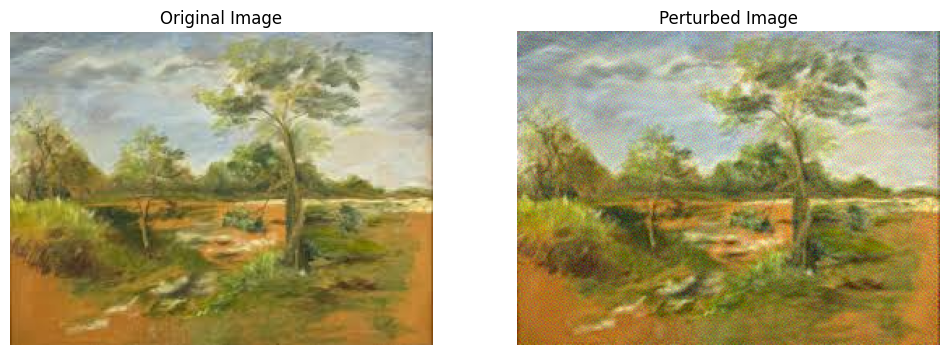

In [ ]:
pert_np = perturbed_vis.squeeze(0).detach().cpu().permute(1,2,0).numpy()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_pil)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(pert_np)
axes[1].set_title("Perturbed Image")
axes[1].axis("off")
plt.show()

In [ ]:
from skimage.feature import SIFT

# convert images to grayscale NumPy arrays
orig_np = np.array(orig_pil.resize((224,224)))
pert_np = (
    perturbed_vis
      .squeeze(0)
      .detach()
      .cpu()
      .permute(1,2,0)
      .numpy()*255
    ).astype(np.uint8)

orig_gray = cv2.cvtColor(orig_np, cv2.COLOR_RGB2GRAY)
pert_gray = cv2.cvtColor(pert_np, cv2.COLOR_RGB2GRAY)

# create SIFT, detect & describe
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(orig_gray, None)
kp2, des2 = sift.detectAndCompute(pert_gray, None)

# match with BF + ratio test
bf = cv2.BFMatcher(cv2.NORM_L2)
raw_matches = bf.knnMatch(des1, des2, k=2)
good_matches = [m for m,n in raw_matches if m.distance < 0.75 * n.distance]

print(f"Original keypoints: {len(kp1)}, Perturbed keypoints: {len(kp2)}")
print(f"Good matches after ratio test: {len(good_matches)}")

# RANSAC to count inliers
if len(good_matches) >= 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    inliers = int(mask.sum())
    print(f"Inliers after RANSAC: {inliers}")
else:
    print("Not enough good matches (<4) for RANSAC.")

Original keypoints: 495, Perturbed keypoints: 498
Good matches after ratio test: 199
Inliers after RANSAC: 185
